In [18]:
import numpy as np
import pandas as pd
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [19]:
# datapreprocess
Greek = pd.read_csv(r'Greek.csv')
inforce = pd.read_csv('inforce.csv')
df = pd.merge(Greek, inforce)
age = (df['currentDate']- df['birthDate'])/365
ttm = (df['matDate']- df['currentDate'])/365
df = df[['recordID','gender','gmwbBalance','productType','gbAmt','FundValue1', 'FundValue2', 'FundValue3', 'FundValue4', 'FundValue5',
       'FundValue6', 'FundValue7', 'FundValue8', 'FundValue9', 'FundValue10', 'fmv']]
df["age"] = age
df['ttm'] = ttm
df = df[['recordID','gender','gmwbBalance','productType','gbAmt','FundValue1', 'FundValue2', 'FundValue3', 'FundValue4', 'FundValue5',
       'FundValue6', 'FundValue7', 'FundValue8', 'FundValue9', 'FundValue10', 'fmv']]
dummy = pd.get_dummies(df[['recordID','productType','gender']], drop_first=True)

df = pd.merge(df, dummy)
df = df.drop(['productType','gender','recordID'], axis=1)

colname = ['gmwbBalance', 'gbAmt', 'FundValue1', 'FundValue2', 'FundValue3',
       'FundValue4', 'FundValue5', 'FundValue6', 'FundValue7', 'FundValue8',
       'FundValue9', 'FundValue10']

# norm = preprocessing.normalize(df[colname])
# df[colname] = norm
df[colname] = (df[colname]-df[colname].mean(0))/(df[colname].max(0)-df[colname].min(0))
df['fmv'] = df['fmv']/1000
import random
random.seed(10)
df = df.sample(frac = 1, replace = False)
df.to_csv('data.csv',index = False)

In [20]:
%%file OLS.py
#!/usr/bin/env python3
from mpi4py import MPI
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import time
import statsmodels.api as sm

def OLS(comm,rank, size):
    if rank == 0:
        data = pd.read_csv("data.csv")
        split_rate = 0.9
        Train = data.iloc[:int(data.shape[0]*split_rate),:]
        Test = data.iloc[int(data.shape[0]*split_rate):,:]

    else:
        # data = None
        Train = None
        Test = None
    # data = comm.bcast(data,root = 0)
    Train = comm.bcast(Train,root = 0)
    Test = comm.bcast(Test,root = 0)

    y_test = Test['fmv']
    X_test = Test.drop(['fmv'],axis = 1)
    X_test = sm.add_constant(X_test)
    y_test_pre_list = []
    error_model_list = []
    for i in range(2):
        Train_sample = Train.sample(frac = 1, replace = True)
        y_train_sample = Train_sample['fmv']
        X_train_sample = Train_sample.drop(['fmv'],axis = 1)
        X_train_sample = sm.add_constant(X_train_sample)
        
        model = sm.OLS(y_train_sample,X_train_sample).fit()
        
        y_train_sample_pre = model.predict(X_train_sample)
        error_model = y_train_sample-y_train_sample_pre
        error_model_list.append(error_model)
        y_test_pre = model.predict(X_test)
        y_test_pre_list.append(y_test_pre)
        print('The rank',rank,'iteration',i)
    error_model_list = np.array(error_model_list)
    y_test_pre_list = np.array(y_test_pre_list)
    y_test_pre_l = np.empty((size,) + y_test_pre_list.shape)
    error_l = np.empty((size,) + error_model_list.shape)
    comm.Gatherv(error_model_list, error_l,root=0)
    comm.Gatherv(y_test_pre_list,y_test_pre_l, root=0)
    if rank == 0:
        y_test_pre_list_ = np.transpose(y_test_pre_l.reshape(y_test_pre_l.shape[0]*y_test_pre_l.shape[1],y_test_pre_l.shape[2]))
        print(y_test_pre_list_.shape)
        error_model_list_ = np.transpose(error_l.reshape(error_l.shape[0]*error_l.shape[1],error_l.shape[2]))
        error_random = np.random.choice(np.array(error_model_list_).flatten(),(y_test_pre_list_.shape))
        y_test_revise_list   = y_test_pre_list_ +   error_random
        Left_list = np.quantile(np.transpose(y_test_revise_list),0.025,axis = 0)
        # print(Left_list.shape)
        Right_list = np.quantile(np.transpose(y_test_revise_list),0.975,axis = 0)
        # print(Right_list.shape)
        Bool_list = (y_test >= Left_list) & (y_test< Right_list)

        diff = Right_list-Left_list
        results_10_1000 = pd.DataFrame([])
        results_10_1000['Left_list'] = np.array(Left_list)
        results_10_1000['Right_list'] = np.array(Right_list)
        results_10_1000['Bool_list'] = np.array(Bool_list)
        results_10_1000['width'] = np.array(diff)
        results_10_1000['test'] = np.array(Test['fmv'].copy())
        pd.DataFrame(results_10_1000).to_csv('./result/results_10_1000.csv',index = False)
        print(f"accuracy: {Bool_list.mean():.6f}")


if __name__ == "__main__":
    # name = MPI.Get_processor_name()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    t = time.time()
    OLS(comm,rank, size)
    print(time.time()-t)
 

Overwriting OLS.py


In [21]:
%%file Huber.py
#!/usr/bin/env python
from mpi4py import MPI
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
import time
import sys


def Huber(comm,rank, size):
    if rank == 0:
        data = pd.read_csv("data.csv")
        split_rate = 0.9
        Train = data.iloc[:int(data.shape[0]*split_rate),:]
        Test = data.iloc[int(data.shape[0]*split_rate):,:]

    else:
        # data = None
        Train = None
        Test = None
    # data = comm.bcast(data,root = 0)
    Train = comm.bcast(Train,root = 0)
    Test = comm.bcast(Test,root = 0)


    y_test = Test['fmv']
    X_test = Test.drop(['fmv'],axis = 1)
    print(rank)
    y_test_pre_list = []
    error_model_list = []
    for i in range(5):
        Train_sample = Train.sample(frac = 1, replace = True)
        y_train_sample = Train_sample['fmv']
        X_train_sample = Train_sample.drop(['fmv'],axis = 1)

        model = HuberRegressor()
        model.fit(X_train_sample,y_train_sample)

        y_train_sample_pre = model.predict(X_train_sample)
        error_model = y_train_sample-y_train_sample_pre
        error_model_list.append(error_model)
        y_test_pre = model.predict(X_test)
        y_test_pre_list.append(y_test_pre)
        print('The rank',rank,'iteration',i)
    error_model_list = np.array(error_model_list)
    y_test_pre_list = np.array(y_test_pre_list)
    y_test_pre_l = np.empty((size,) + y_test_pre_list.shape)
    error_l = np.empty((size,) + error_model_list.shape)
    comm.Gatherv(error_model_list, error_l,root=0)
    comm.Gatherv(y_test_pre_list,y_test_pre_l, root=0)
    if rank == 0:
        y_test_pre_list_ = np.transpose(y_test_pre_l.reshape(y_test_pre_l.shape[0]*y_test_pre_l.shape[1],y_test_pre_l.shape[2]))
        # print(y_test_pre_list_.shape)
        error_model_list_ = np.transpose(error_l.reshape(error_l.shape[0]*error_l.shape[1],error_l.shape[2]))
        error_random = np.random.choice(np.array(error_model_list_).flatten(),(y_test_pre_list_.shape))
        y_test_revise_list   = y_test_pre_list_ +   error_random
        Left_list = np.quantile(np.transpose(y_test_revise_list),0.025,axis = 0)
        print(Left_list.shape)
        Right_list = np.quantile(np.transpose(y_test_revise_list),0.975,axis = 0)
        print(Right_list.shape)
        Bool_list = (y_test >= Left_list) & (y_test< Right_list)
        
        diff = Right_list-Left_list
        results_10_1000 = pd.DataFrame([])
        results_10_1000['Left_list'] = np.array(Left_list)
        results_10_1000['Right_list'] = np.array(Right_list)
        results_10_1000['Bool_list'] = np.array(Bool_list)
        results_10_1000['width'] = np.array(diff)
        results_10_1000['test'] = np.array(Test['fmv'].copy())
        pd.DataFrame(results_10_1000).to_csv('./result/results_10_1000.csv',index = False)
        print(f"accuracy: {Bool_list.mean():.6f}")


if __name__ == "__main__":
    # name = MPI.Get_processor_name()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    t = time.time()
    Huber(comm,rank, size)
    print((time.time()-t))


Overwriting Huber.py


In [22]:
%%file RANSACR.py
#!/usr/bin/env python
from mpi4py import MPI
import numpy as np
import pandas as pd
# from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
import time
import sys


def RANSACR(comm,rank, size):
    if rank == 0:
        data = pd.read_csv("data.csv")
        split_rate = 0.9
        Train = data.iloc[:int(data.shape[0]*split_rate),:]
        Test = data.iloc[int(data.shape[0]*split_rate):,:]

    else:
        # data = None
        Train = None
        Test = None
    # data = comm.bcast(data,root = 0)
    Train = comm.bcast(Train,root = 0)
    Test = comm.bcast(Test,root = 0)


    y_test = Test['fmv']
    X_test = Test.drop(['fmv'],axis = 1)
    print(rank)
    y_test_pre_list = []
    error_model_list = []
    for i in range(2):
        Train_sample = Train.sample(frac = 1, replace = True)
        y_train_sample = Train_sample['fmv']
        X_train_sample = Train_sample.drop(['fmv'],axis = 1)

        model = RANSACRegressor()
        model.fit(X_train_sample,y_train_sample)

        y_train_sample_pre = model.predict(X_train_sample)
        error_model = y_train_sample-y_train_sample_pre
        error_model_list.append(error_model)
        y_test_pre = model.predict(X_test)
        y_test_pre_list.append(y_test_pre)
        print('The rank',rank,'iteration',i)
    error_model_list = np.array(error_model_list)
    y_test_pre_list = np.array(y_test_pre_list)
    y_test_pre_l = np.empty((size,) + y_test_pre_list.shape)
    error_l = np.empty((size,) + error_model_list.shape)
    comm.Gatherv(error_model_list, error_l,root=0)
    comm.Gatherv(y_test_pre_list,y_test_pre_l, root=0)
    if rank == 0:
        y_test_pre_list_ = np.transpose(y_test_pre_l.reshape(y_test_pre_l.shape[0]*y_test_pre_l.shape[1],y_test_pre_l.shape[2]))
        print(y_test_pre_list_.shape)
        error_model_list_ = np.transpose(error_l.reshape(error_l.shape[0]*error_l.shape[1],error_l.shape[2]))
        error_random = np.random.choice(np.array(error_model_list_).flatten(),(y_test_pre_list_.shape))
        y_test_revise_list   = y_test_pre_list_ +   error_random
        Left_list = np.quantile(np.transpose(y_test_revise_list),0.025,axis = 0)
        # print(Left_list.shape)
        Right_list = np.quantile(np.transpose(y_test_revise_list),0.975,axis = 0)
        # print(Right_list.shape)
        Bool_list = (y_test >= Left_list) & (y_test< Right_list)

        diff = Right_list-Left_list
        results_10_1000 = pd.DataFrame([])
        results_10_1000['Left_list'] = np.array(Left_list)
        results_10_1000['Right_list'] = np.array(Right_list)
        results_10_1000['Bool_list'] = np.array(Bool_list)
        results_10_1000['width'] = np.array(diff)
        results_10_1000['test'] = np.array(Test['fmv'].copy())
        pd.DataFrame(results_10_1000).to_csv('./result/results_10_1000.csv',index = False)
        print(f"accuracy: {Bool_list.mean():.6f}")


if __name__ == "__main__":
    # name = MPI.Get_processor_name()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    t = time.time()
    RANSACR(comm,rank, size)
    print(time.time()-t)


Overwriting RANSACR.py


In [23]:
%%file quantile.py
from mpi4py import MPI
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import sys
import statsmodels.regression.quantile_regression as Q_reg


def quantile(comm,rank, size):
    if rank == 0:
        data = pd.read_csv("data.csv")
        split_rate = 0.9
        Train = data.iloc[:int(data.shape[0]*split_rate),:]
        Test = data.iloc[int(data.shape[0]*split_rate):,:]

    else:
        # data = None
        Train = None
        Test = None
    # data = comm.bcast(data,root = 0)
    Train = comm.bcast(Train,root = 0)
    Test = comm.bcast(Test,root = 0)


    y_test = Test['fmv']
    X_test = Test.drop(['fmv'],axis = 1)
    # print(rank)
    y_test_pre_left = []
    y_test_pre_right = []
    for i in range(3):
        print('The rank',rank,'iteration',i)
        Train_sample = Train.sample(frac = 1, replace = True)
        y_train_sample = Train_sample['fmv']
        X_train_sample = Train_sample.drop(['fmv'],axis = 1)
        Y_test_pred_left = Q_reg.QuantReg(y_train_sample, X_train_sample).fit(q=0.025).predict(X_test)
        Y_test_pred_right = Q_reg.QuantReg(y_train_sample, X_train_sample).fit(q=0.975).predict(X_test)
        y_test_pre_left.append(Y_test_pred_left)
        y_test_pre_right.append(Y_test_pred_right)
        

    y_test_pre_left = np.array(y_test_pre_left)
    y_test_pre_l = np.empty((size,) +y_test_pre_left.shape)
    y_test_pre_right = np.array(y_test_pre_right)
    y_test_pre_r = np.empty((size,) +y_test_pre_right.shape)
    comm.Gatherv(y_test_pre_left, y_test_pre_l,root=0)
    comm.Gatherv(y_test_pre_right,y_test_pre_r, root=0)
    if rank == 0:
        y_test_pre_l_list = np.transpose(y_test_pre_l.reshape(y_test_pre_l.shape[0]*y_test_pre_l.shape[1],y_test_pre_l.shape[2]))
        y_test_pre_r_list = np.transpose(y_test_pre_r.reshape(y_test_pre_r.shape[0]*y_test_pre_r.shape[1],y_test_pre_r.shape[2]))
        Left_list = np.quantile(np.transpose(y_test_pre_l_list),0.5,axis = 0)
        Right_list = np.quantile(np.transpose(y_test_pre_r_list),0.5,axis = 0)
        Bool_list = (y_test >= Left_list) & (y_test< Right_list)
        diff = Right_list-Left_list
        results_10_1000 = pd.DataFrame([])
        results_10_1000['Left_list'] = np.array(Left_list)
        results_10_1000['Right_list'] = np.array(Right_list)
        results_10_1000['Bool_list'] = np.array(Bool_list)
        results_10_1000['width'] = np.array(diff)
        results_10_1000['test'] = np.array(Test['fmv'].copy())
        pd.DataFrame(results_10_1000).to_csv('./result/results_10_1000.csv',index = False)
        print(f"accuracy: {Bool_list.mean():.6f}")


if __name__ == "__main__":
    # name = MPI.Get_processor_name()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    t = time.time()
    quantile(comm,rank, size)
    print(time.time()-t)


Overwriting quantile.py


In [24]:
%%file GBoost.py
#!/usr/bin/env python
from mpi4py import MPI
import numpy as np
import pandas as pd
# from sklearn.linear_model import HuberRegressor
# from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import time
import sys


def GBoost(comm,rank, size):
    if rank == 0:
        data = pd.read_csv("data.csv")
        split_rate = 0.9
        Train = data.iloc[:int(data.shape[0]*split_rate),:]
        Test = data.iloc[int(data.shape[0]*split_rate):,:]

    else:
        # data = None
        Train = None
        Test = None
    # data = comm.bcast(data,root = 0)
    Train = comm.bcast(Train,root = 0)
    Test = comm.bcast(Test,root = 0)


    y_test = Test['fmv']
    X_test = Test.drop(['fmv'],axis = 1)
    print(rank)
    y_test_pre_list = []
    error_model_list = []
    for i in range(2):
        Train_sample = Train.sample(frac = 1, replace = True)
        y_train_sample = Train_sample['fmv']
        X_train_sample = Train_sample.drop(['fmv'],axis = 1)

        model = GradientBoostingRegressor()
        model.fit(X_train_sample,y_train_sample)
        y_train_sample_pre = model.predict(X_train_sample)
        error_model = y_train_sample-y_train_sample_pre
        error_model_list.append(error_model)
        y_test_pre = model.predict(X_test)
        y_test_pre_list.append(y_test_pre)
        print('The rank',rank,'iteration',i)
    error_model_list = np.array(error_model_list)
    y_test_pre_list = np.array(y_test_pre_list)
    y_test_pre_l = np.empty((size,) + y_test_pre_list.shape)
    error_l = np.empty((size,) + error_model_list.shape)
    comm.Gatherv(error_model_list, error_l,root=0)
    comm.Gatherv(y_test_pre_list,y_test_pre_l, root=0)
    if rank == 0:
        y_test_pre_list_ = np.transpose(y_test_pre_l.reshape(y_test_pre_l.shape[0]*y_test_pre_l.shape[1],y_test_pre_l.shape[2]))
        print(y_test_pre_list_.shape)
        error_model_list_ = np.transpose(error_l.reshape(error_l.shape[0]*error_l.shape[1],error_l.shape[2]))
        error_random = np.random.choice(np.array(error_model_list_).flatten(),(y_test_pre_list_.shape))
        y_test_revise_list   = y_test_pre_list_ +   error_random
        Left_list = np.quantile(np.transpose(y_test_revise_list),0.025,axis = 0)
        # print(Left_list.shape)
        Right_list = np.quantile(np.transpose(y_test_revise_list),0.975,axis = 0)
        # print(Right_list.shape)
        Bool_list = (y_test >= Left_list) & (y_test< Right_list)

        diff = Right_list-Left_list
        results_10_1000 = pd.DataFrame([])
        results_10_1000['Left_list'] = np.array(Left_list)
        results_10_1000['Right_list'] = np.array(Right_list)
        results_10_1000['Bool_list'] = np.array(Bool_list)
        results_10_1000['width'] = np.array(diff)
        results_10_1000['test'] = np.array(Test['fmv'].copy())
        pd.DataFrame(results_10_1000).to_csv('./result/results_10_1000.csv',index = False)
        print(f"accuracy: {Bool_list.mean():.6f}")


if __name__ == "__main__":
    # name = MPI.Get_processor_name()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    t = time.time()
    GBoost(comm,rank, size)
    print(time.time()-t)


Overwriting GBoost.py


In [54]:
# analysis the data in 10%
def readfile(modelname,splitrate,resample):
    path = "./" + modelname + "/result/"
    return pd.read_csv(path + "results_" + str(splitrate)+"_"+str(resample)+".csv")

def readata(rate,iteration):
    df_Huber = readfile("Huber",rate,iteration)
    df_RANSAC = readfile("RANSAC",rate,iteration)
    df_OLS = readfile("OLS",rate,iteration)
    df_quantile = readfile("quantile",rate,iteration)
    df_GradientBoost = readfile("GradientBoost",rate,iteration)
    return df_Huber,df_RANSAC,df_OLS,df_quantile,df_GradientBoost

In [55]:
# df_Huber,df_RANSAC,df_OLS,df_quantile,df_GradientBoost = readata(10,1000)

rate 10; iteration1000
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -50.539     0.000   -53.746   -47.331
 (0 - 2)   -280.727     0.000  -283.935  -277.520
 (0 - 3)     98.898     0.000    95.691   102.106
 (0 - 4)    129.200     0.000   125.992   132.407
 (1 - 0)     50.539     0.000    47.331    53.746
 (1 - 2)   -230.189     0.000  -233.396  -226.981
 (1 - 3)    149.437     0.000   146.230   152.644
 (1 - 4)    179.738     0.000   176.531   182.946
 (2 - 0)    280.727     0.000   277.520   283.935
 (2 - 1)    230.189     0.000   226.981   233.396
 (2 - 3)    379.626     0.000   376.418   382.833
 (2 - 4)    409.927     0.000   406.720   413.135
 (3 - 0)    -98.898     0.000  -102.106   -95.691
 (3 - 1)   -149.437     0.000  -152.644  -146.230
 (3 - 2)   -379.626     0.000  -382.833  -376.418
 (3 - 4)     30.302     0.000    27.094    33.509
 (4 - 0)   -129.200     0.000  -132.407  -125.992
 (4 - 1) 

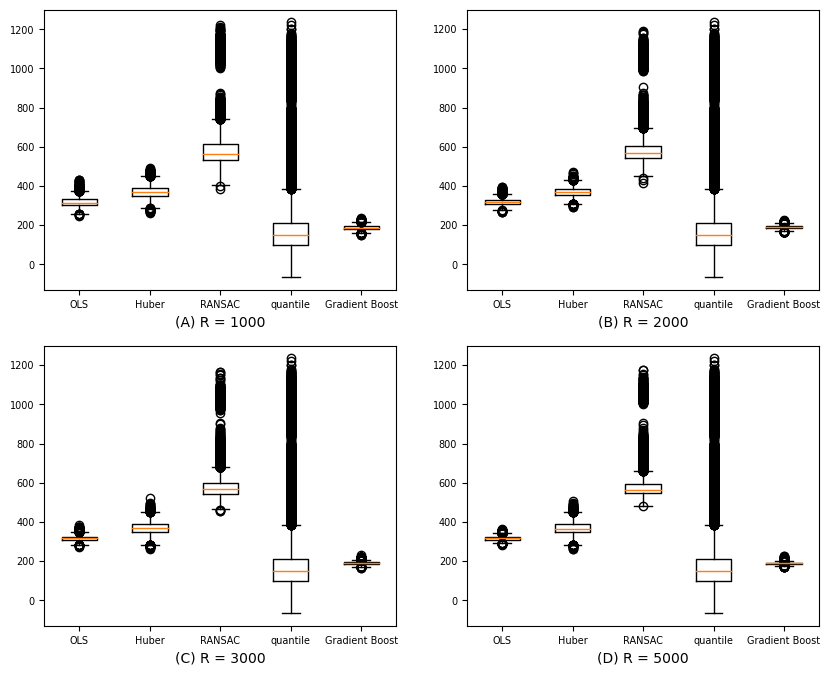

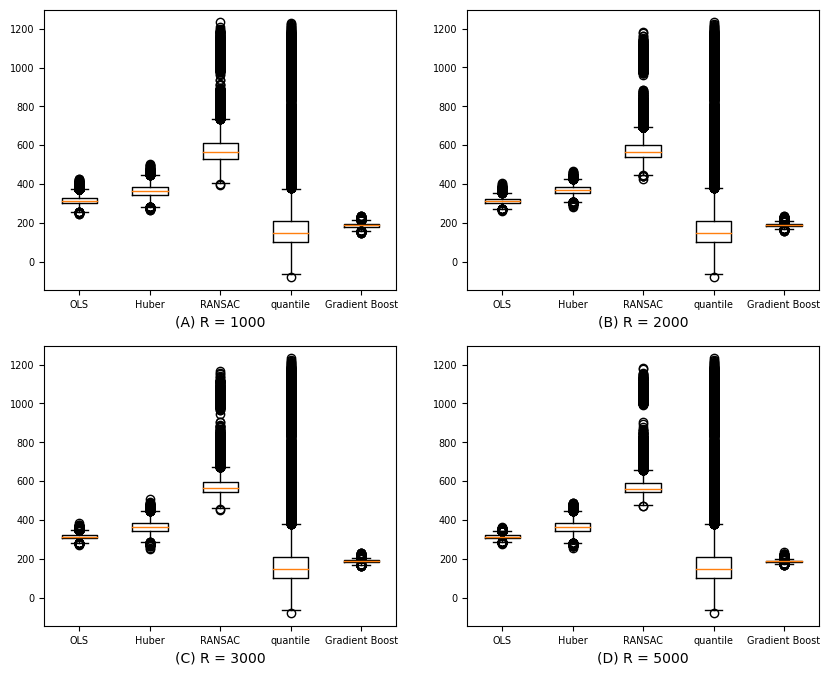

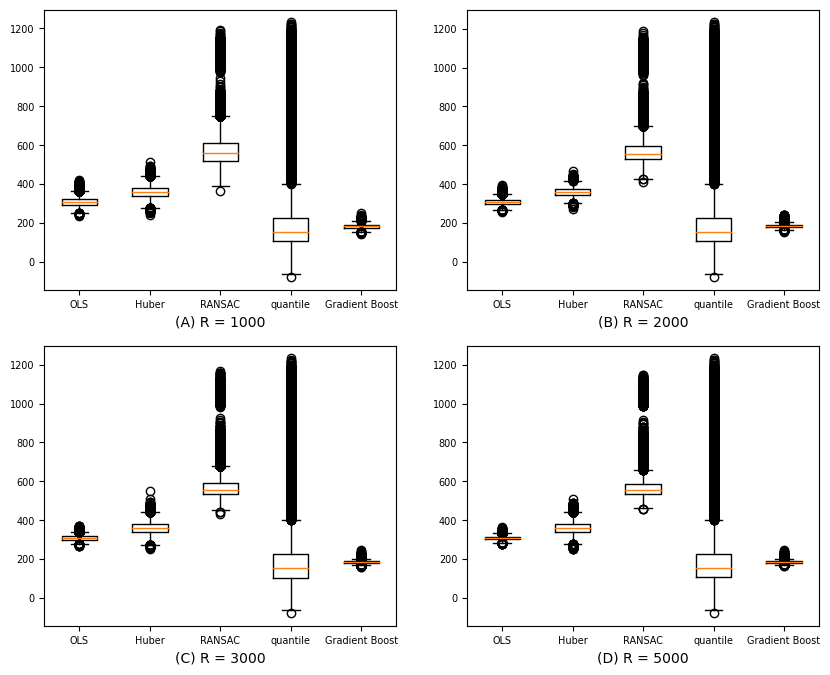

In [65]:
# difference test
# rate = 10
rate_list = [10,20,30]
itera = [1000,2000,3000,5000]
letter = ["(A)","(B)","(C)","(D)"]
for rate in rate_list:
    h = 0
    fig, ax = plt.subplots(2, 2,figsize=(10,8))
    for i in range(2):
        for j in range(2):
            df_Huber,df_RANSAC,df_OLS,df_quantile,df_GradientBoost = readata(rate,itera[h])
            ax[i,j].tick_params(axis='both', which='major', labelsize=7)
            ax[i,j].tick_params(axis='both', which='minor', labelsize=7)
            ax[i,j].boxplot([df_OLS['width'],df_Huber['width'], df_RANSAC['width'],df_quantile['width'],df_GradientBoost['width']])
            ax[i,j].set_xticklabels(["OLS","Huber", "RANSAC","quantile","Gradient Boost"]) 
            ax[i,j].set_xlabel("{} R = {}".format(letter[h],itera[h]))
            
            res = tukey_hsd(df_OLS['width'],df_Huber['width'], df_RANSAC['width'],df_quantile['width'],df_GradientBoost['width'])
            print("rate {}; iteration{}".format(rate,itera[h]))
            print(res)
            h = h+1
    # plt.title("Split Rate = {}%".format(rate))
    plt.savefig('./figure/rate_{}.png'.format(rate))